In [2]:
import matplotlib.pyplot as plt
import numpy as np

# MeshMaker

This python notebook uses the triangle program to generate a Dulaunay Triangulation for use in the `proto_xpt` program.

Set the points in the polygon

In [3]:
pts = [[0,0], [10,0], [0,10], [10,10]]

Define segments, indexed to 1:

In [4]:
segs = [[0,1], [0,2], [1,3], [2,3]]

Set the maximum size of elements and filename:

In [5]:
max_area = 0.5
filename = '2dcartesian/square_mesh_10x10'

In [6]:
def make_poly(pts, segs, filename='mesh.poly'):
    with open(filename, 'w') as f:
        f.write(str(len(pts)) + " 2 0 0\n")
        for i, pt in enumerate(pts):
            f.write(str(i+1) + " " + str(pt[0]) + " " + str(pt[1]) + "\n")
        f.write(str(len(segs)) + " 0\n")
        for i, seg in enumerate(segs):
            f.write(str(i+1) + " " + str(seg[0] + 1) + " " + str(seg[1] + 1) + "\n")
        f.write("0")

In [7]:
make_poly(pts, segs, filename + '.poly')

In [8]:
!./triangle -q -a{max_area} {filename}.poly

Opening 2dcartesian/square_mesh_10x10.poly.
Constructing Delaunay triangulation by divide-and-conquer method.
Delaunay milliseconds:  0
Recovering segments in Delaunay triangulation.
Segment milliseconds:  0
Removing unwanted triangles.
Hole milliseconds:  0
Adding Steiner points to enforce quality.
Quality milliseconds:  0

Writing 2dcartesian/square_mesh_10x10.1.node.
Writing 2dcartesian/square_mesh_10x10.1.ele.
Writing 2dcartesian/square_mesh_10x10.1.poly.

Output milliseconds:  0
Total running milliseconds:  1

Statistics:

  Input vertices: 4
  Input segments: 4
  Input holes: 0

  Mesh vertices: 173
  Mesh triangles: 311
  Mesh edges: 483
  Mesh exterior boundary edges: 33
  Mesh interior boundary edges: 0
  Mesh subsegments (constrained edges): 33



In [9]:
with open(filename + '.1.node', 'r') as f:
    nodes = f.readlines()
nodes = [line.strip() for line in nodes[1:-1]]
nodes = [line.split()[1:-1] for line in nodes]
x = [float(node[0]) for node in nodes]
y = [float(node[1]) for node in nodes]

In [10]:
with open(filename + '.1.ele', 'r') as f:
    ele = f.readlines()
ele = [line.strip() for line in ele[1:-1]]
ele = [line.split()[1:] for line in ele]
ele = [[int(v) - 1 for v in line] for line in ele]

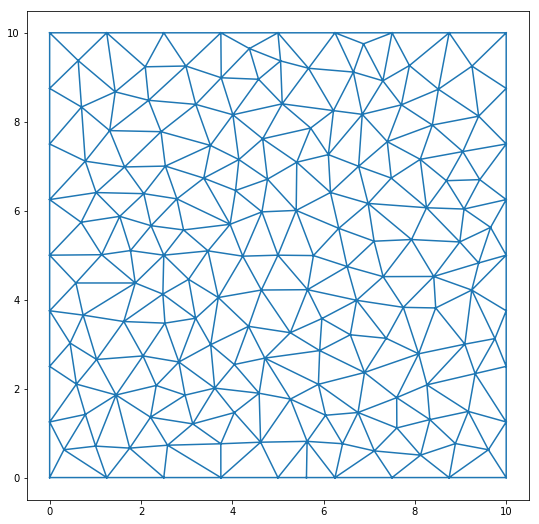

In [11]:
plt.figure(figsize=(9,9))
plt.triplot(x,y,ele)
plt.show()

In [12]:
!protoc --python_out="." mesh2dcartesian.proto

In [13]:
import mesh2dcartesian_pb2 as mesh_proto

# Make Mesh Serialized File

In [14]:
mesh = mesh_proto.Mesh2DCartesian()

In [15]:
mesh.x_min = np.min(x)
mesh.x_max = np.max(x)
mesh.y_min = np.min(y)
mesh.y_max = np.max(y)

In [16]:
del mesh.nodes[:]
new_nodes = []
for i in range(len(x)):
    new_node = mesh.Node()
    new_node.x = x[i]
    new_node.y = y[i]
    new_nodes.append(new_node)
mesh.nodes.extend(new_nodes)

In [17]:
del mesh.triangles[:]
new_triangles = []
for triangle in ele:
    new_triangle = mesh.Triangle()
    new_triangle.nodes[:] = triangle
    new_triangles.append(new_triangle)
mesh.triangles.extend(new_triangles)

In [19]:
f = open(filename + '.mesh2dcartesian', 'wb')
f.write(mesh.SerializeToString())
f.close()